# Bike Sharing Analysis in the SF Bay Area


<span style="color: gray; font-size:1em;">Kolin Schunck</span>
<br><span style="color: gray; font-size:1em;">April 27, 2020</span>


## Table of Contents
- [Introduction](#intro)
- [Part I - Data Gathering](#gather)
- [Part II - Data Assessment](#assess)
- [Part III - Data Cleaning](#clean)
- [Part IV - Univariate Analysis](#univariate)
- [Part V - Bivariate Analysis](#bivariate)
- [Part VI - Multivariate Analysis](#multivariate)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

Bay Wheels is a regional public bicycle sharing system in the San Francisco Bay Area, California operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States. It was established as Bay Area Bike Share in August 2013. As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose. On June 28, 2017, the system officially re-launched as Ford GoBike in a partnership with Ford Motor Company. After Motivate's acquisition by Lyft, the system was subsequently renamed to Bay Wheels in June 2019. The system is expected to expand to 7,000 bicycles around 540 stations in San Francisco, Oakland, Berkeley, Emeryville, and San Jose.

The bicycles are available 24 hours a day, seven days a week for periods ranging from a single ride (up to 30 minutes) to a day pass, in 30-minute increments, or customers can purchase an annual subscription which gives them unlimited rides up to 45-minutes in duration. Single rides cost USD2 per trip, day passes cost USD10 per day, and memberships cost USD15 per month or USD149 per year.

A reduced pricing option called "Bike Share for All" exists for users who qualify for CalFresh, the SFMTA's Lifeline pass, or PG & E's CARE discount. The reduced price is USD5/year for the first year and USD5/month in subsequent years. This membership option provides rides of 60 minutes without an additional charge. As of January 2018, around 15% of the membership of the bikeshare system used the Bike Share for All option.

#### Pre Data Wrangling

This document explores the Bay Wheel's trip data for bike rides FY2019.
Bay Wheel's Data: https://s3.amazonaws.com/baywheels-data/index.html

<a id='gather'></a>
## Part I - Data Gathering

In [82]:
# import all packages and set plots to be embedded inline
import requests, zipfile
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
from glob import glob
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

In [83]:
# download the first dataset Jan-Apr 2019 with pandas
folder_name_of_csvs = 'sfbay_trip_data_files'

In [84]:
makedirs(folder_name_of_csvs)

for month in range(1,5):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/baywheels-data/2019' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder sfbay_trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [85]:
# download the 2nd dataset May - Dec 2019 with pandas
folder_name_of_csvs2 = 'sfbay_trip_data_files_2'

In [86]:
makedirs(folder_name_of_csvs2)

for month in range(5,13):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/baywheels-data/2019' + month_leading_zero + '-baywheels-tripdata.csv.zip'
    response = get(bike_data_url)
    
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder sfbay_trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [100]:
# combine All locally saved CSVs into one DataFrame
import glob
import os

path ='./sfbay_trip_data_files'
all_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index = True)
df.to_csv('master_file.csv', index=False)

In [101]:
# load the dataset
df = pd.read_csv('master_file.csv')

<a id='assess'></a>
## Part II - Data Assessment

In [102]:
# visually check first 5 records
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,60863,2019-09-30 11:48:02.7100,2019-10-01 04:42:25.8640,465.0,San Francisco Caltrain Station (King St at 4th...,37.776329,-122.394438,465.0,San Francisco Caltrain Station (King St at 4th...,37.776329,-122.394438,12904,Customer,No,NaN
1,36019,2019-09-30 16:16:32.3530,2019-10-01 02:16:51.9820,294.0,Pierce Ave at Market St,37.327581,-121.884559,443.0,3rd St at Keyes St,37.320866,-121.876279,163,Customer,No,NaN
2,5615,2019-09-30 23:12:25.9980,2019-10-01 00:46:01.9590,370.0,Jones St at Post St,37.787327,-122.413278,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,10737,Customer,No,NaN
3,1482,2019-09-30 23:57:34.6630,2019-10-01 00:22:16.8490,109.0,17th St at Valencia St,37.763316,-122.421904,460.0,Terry Francois Blvd at Warriors Way,37.769095,-122.386333,10346,Customer,No,NaN
4,1272,2019-09-30 23:53:28.6530,2019-10-01 00:14:41.0740,95.0,Sanchez St at 15th St,37.766219,-122.431060,127.0,Valencia St at 21st St,37.756708,-122.421025,1349,Subscriber,No,NaN


In [103]:
# visually check 20 random records
df.sample(20)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
347816,1001,2019-03-16 22:46:31.1090,2019-03-16 23:03:12.4510,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,323.0,Broadway at Kearny,37.798014,-122.405950,623,Customer,No,NaN
1671505,942,2019-08-13 08:08:38.9940,2019-08-13 08:24:21.4910,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,58.0,Market St at 10th St,37.776619,-122.417385,762,Subscriber,No,NaN
2173643,1468,2019-12-31 06:42:36.1110,2019-12-31 07:07:04.4920,375.0,Grove St at Masonic Ave,37.774836,-122.446546,19.0,Post St at Kearny St,37.788975,-122.403452,10213,Subscriber,NaN,NaN
797853,1023,2019-04-20 15:45:55.6860,2019-04-20 16:02:59.0200,53.0,Grove St at Divisadero,37.775946,-122.437777,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,419,Customer,No,NaN
205630,871,2019-09-03 17:07:45.7540,2019-09-03 17:22:16.9520,22.0,Howard St at Beale St,37.789756,-122.394643,90.0,Townsend St at 7th St,37.771058,-122.402717,9661,Subscriber,No,NaN
1934716,732,2019-10-31 16:30:18.1440,2019-10-31 16:42:30.7290,182.0,19th Street BART Station,37.809369,-122.267951,194.0,Lakeshore Ave at Trestle Glen Rd,37.811081,-122.243268,12815,Subscriber,No,NaN
2339465,429,2019-11-25 07:31:42.0220,2019-11-25 07:38:51.9350,9.0,Broadway at Battery St,37.798572,-122.400869,22.0,Howard St at Beale St,37.789756,-122.394643,9504,Subscriber,No,NaN
1887835,832,2019-05-07 20:21:03.2840,2019-05-07 20:34:55.4980,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,92.0,Mission Bay Kids Park,37.772301,-122.393028,379,Subscriber,No,NaN
2323782,814,2019-11-29 10:44:23.5750,2019-11-29 10:57:58.2480,262.0,West St at University Ave,37.869967,-122.286533,254.0,Vine St at Shattuck Ave,37.880222,-122.269592,12308,Customer,No,NaN
9801,2771,2019-09-29 15:41:17.3960,2019-09-29 16:27:29.0050,368.0,Myrtle St at Polk St,37.785434,-122.419622,59.0,S Van Ness Ave at Market St,37.774814,-122.418954,9469,Customer,No,NaN


In [104]:
# view info of the dataframe
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   duration_sec             2506983 non-null  int64  
 1   start_time               2506983 non-null  object 
 2   end_time                 2506983 non-null  object 
 3   start_station_id         2426249 non-null  float64
 4   start_station_name       2426850 non-null  object 
 5   start_station_latitude   2506983 non-null  float64
 6   start_station_longitude  2506983 non-null  float64
 7   end_station_id           2424081 non-null  float64
 8   end_station_name         2424633 non-null  object 
 9   end_station_latitude     2506983 non-null  float64
 10  end_station_longitude    2506983 non-null  float64
 11  bike_id                  2506983 non-null  int64  
 12  user_type                2506983 non-null  object 
 13  bike_share_for_all_trip  2263724 non-null 

In [105]:
# check if duplicates exist
df.duplicated().sum()

0

In [106]:
# view descriptive statistics of the dataframe
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id
count,2.506983e+06,2.426249e+06,2.506983e+06,2.506983e+06,2.424081e+06,2.506983e+06,2.506983e+06,2.506983e+06
mean,8.076483e+02,1.465047e+02,3.776506e+01,-1.223499e+02,1.427044e+02,3.776422e+01,-1.223459e+02,2.789833e+04
std,1.974714e+03,1.223171e+02,1.363698e-01,3.089648e-01,1.214296e+02,2.392885e-01,7.080417e-01,1.146067e+05
min,6.000000e+01,3.000000e+00,0.000000e+00,-1.225143e+02,3.000000e+00,0.000000e+00,-1.225143e+02,4.000000e+00
25%,3.590000e+02,4.700000e+01,3.776931e+01,-1.224130e+02,4.300000e+01,3.777003e+01,-1.224117e+02,1.952000e+03
50%,5.710000e+02,1.050000e+02,3.778053e+01,-1.223983e+02,1.010000e+02,3.778076e+01,-1.223981e+02,4.420000e+03
75%,8.870000e+02,2.430000e+02,3.779539e+01,-1.222914e+02,2.390000e+02,3.779587e+01,-1.222934e+02,9.682000e+03
max,9.121100e+05,4.980000e+02,4.551000e+01,0.000000e+00,4.980000e+02,4.551000e+01,0.000000e+00,9.999410e+05


<a id='issues'></a>
**Quality issues**
 * start time and end time are objects not a timestamps
 * user_type and bike_share_for_all_trip can be set to category
 * bike_id, start_station_id, end_station_id can be set to object
 * we can further enhance the dataset with more details about the time like month, day, hour, weekday
 * we can calculate the distance for rides between stations

<a id='clean'></a>
## Part III - Data Cleaning

In [107]:
# create copies of original DataFrames
df_clean = df.copy()

**Define**
<br>Set appropriate data types for fields mentioned in the [Quality issues](#issues)

**Code**

In [108]:
# set dates to timestamps
df_clean.start_time = pd.to_datetime(df_clean.start_time)
df_clean.end_time = pd.to_datetime(df_clean.end_time)

In [110]:
# set user type, gender and bike_share_for_all_trip to category
df_clean.user_type = df_clean.user_type.astype('category')
df_clean.bike_share_for_all_trip = df_clean.bike_share_for_all_trip.astype('category')

In [111]:
# set bike id, start_station_id, end_station_id to object
df_clean.bike_id = df_clean.bike_id.astype(str)
df_clean.start_station_id = df_clean.bike_id.astype(str)
df_clean.end_station_id = df_clean.bike_id.astype(str)

**Test**

In [112]:
df_clean.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   duration_sec             2506983 non-null  int64         
 1   start_time               2506983 non-null  datetime64[ns]
 2   end_time                 2506983 non-null  datetime64[ns]
 3   start_station_id         2506983 non-null  object        
 4   start_station_name       2426850 non-null  object        
 5   start_station_latitude   2506983 non-null  float64       
 6   start_station_longitude  2506983 non-null  float64       
 7   end_station_id           2506983 non-null  object        
 8   end_station_name         2424633 non-null  object        
 9   end_station_latitude     2506983 non-null  float64       
 10  end_station_longitude    2506983 non-null  float64       
 11  bike_id                  2506983 non-null  object        
 12  

**Define**
<br>Enhance dataset with new date related fields

**Code**

In [113]:
# extract start time month name
df_clean['start_time_month_name']=df_clean['start_time'].dt.strftime('%B')

In [114]:
# extract start time month number
df_clean['start_time_month']=df_clean['start_time'].dt.month.astype(int)

In [115]:
# extract start time weekdays
df_clean['start_time_weekday']=df_clean['start_time'].dt.strftime('%a')

In [116]:
# extract start time day
df_clean['start_time_day']=df_clean['start_time'].dt.day.astype(int)

In [117]:
# extract start time hour
df_clean['start_time_hour']=df_clean['start_time'].dt.hour

**Test**

In [121]:
df_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method,start_time_month_name,start_time_month,start_time_weekday,start_time_day,start_time_hour
0,60863,2019-09-30 11:48:02.710,2019-10-01 04:42:25.864,12904,San Francisco Caltrain Station (King St at 4th...,37.776329,-122.394438,12904,San Francisco Caltrain Station (King St at 4th...,37.776329,-122.394438,12904,Customer,No,NaN,September,9,Mon,30,11
1,36019,2019-09-30 16:16:32.353,2019-10-01 02:16:51.982,163,Pierce Ave at Market St,37.327581,-121.884559,163,3rd St at Keyes St,37.320866,-121.876279,163,Customer,No,NaN,September,9,Mon,30,16
2,5615,2019-09-30 23:12:25.998,2019-10-01 00:46:01.959,10737,Jones St at Post St,37.787327,-122.413278,10737,Cyril Magnin St at Ellis St,37.785881,-122.408915,10737,Customer,No,NaN,September,9,Mon,30,23
3,1482,2019-09-30 23:57:34.663,2019-10-01 00:22:16.849,10346,17th St at Valencia St,37.763316,-122.421904,10346,Terry Francois Blvd at Warriors Way,37.769095,-122.386333,10346,Customer,No,NaN,September,9,Mon,30,23
4,1272,2019-09-30 23:53:28.653,2019-10-01 00:14:41.074,1349,Sanchez St at 15th St,37.766219,-122.431060,1349,Valencia St at 21st St,37.756708,-122.421025,1349,Subscriber,No,NaN,September,9,Mon,30,23


In [130]:
df_clean.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 20 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   duration_sec             2506983 non-null  int64         
 1   start_time               2506983 non-null  datetime64[ns]
 2   end_time                 2506983 non-null  datetime64[ns]
 3   start_station_id         2506983 non-null  object        
 4   start_station_name       2426850 non-null  object        
 5   start_station_latitude   2506983 non-null  float64       
 6   start_station_longitude  2506983 non-null  float64       
 7   end_station_id           2506983 non-null  object        
 8   end_station_name         2424633 non-null  object        
 9   end_station_latitude     2506983 non-null  float64       
 10  end_station_longitude    2506983 non-null  float64       
 11  bike_id                  2506983 non-null  object        
 12  

In [131]:
# save cleaned data 
df_clean.to_csv('clean_master_file.csv', index=False)

### What is the structure of your dataset?

Originally there were approx. 2,506,983 bike id counts in the FY2019 in the San Francisco Bay Area. The dataset contained features about:
 * trip duration: start/end time, how long the trip took in seconds
 * stations: start/end station, name, geolocation (latitude/longitude)
 * anonymized customer data: user type
 * rented bikes: bike id

The dataset was further enhanced with features that I may find neccessary to perform interesting analysis:
 * rental time: month, day, hour of the day, weekday (both for start and end date)
 

### What is/are the main feature(s) of interest in your dataset?

The following are the most interesting aspects for further analysis: 
* Average riding duration
* Average riding distance
* Weekly day distribution
* Demand (when is demand highest)
* Usage of service (members vs. leisure riders)


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that the start time will be most exploited in my analysis as well as purpose related data. I expect that location and datetime will have the strongest effect on bike demand.


<a id='univariate'></a>
## Part IV - Univariate Analysis


### Q.1 How is Bay Wheels growing?

**Average count of rides per bike per day**

#### Preparatory Work

In [132]:
#Generate new fields for date from start_time and end_time
df_clean['start_time']=pd.to_datetime(df_clean['start_time'])
df_clean['end_time']=pd.to_datetime(df_clean['end_time'])

In [133]:
df_clean['start_time_date']=df_clean['start_time'].dt.date
df_clean['end_time_date']=df_clean['end_time'].dt.date

In [134]:
df_clean['start_time_year_month']=df_clean['start_time'].map(lambda x: x.strftime('%Y-%m'))
df_clean['end_time_year_month']=df_clean['end_time'].map(lambda x: x.strftime('%Y-%m'))

In [135]:
df_clean['start_time_year_month_renamed'] = df_clean['start_time'].dt.strftime('%y' + '-' + '%m')

In [136]:
df_clean['start_time_year']=df_clean['start_time'].dt.year.astype(int)
df_clean['end_time_year']=df_clean['end_time'].dt.year.astype(int)

In [137]:
df_clean['start_time_month']=df_clean['start_time'].dt.month.astype(int)
df_clean['end_time_month']=df_clean['end_time'].dt.month.astype(int)

In [138]:
df_clean['start_time_hour_minute']=df_clean['start_time'].map(lambda x: x.strftime('%H-%m'))
df_clean['end_time_hour_minute']=df_clean['end_time'].map(lambda x: x.strftime('%H-%m'))

In [141]:
df_clean['start_time_hour']=df_clean['start_time'].dt.hour
df_clean['end_time_hour']=df_clean['end_time'].dt.hour

In [144]:
df_clean['start_time_weekday']=df_clean['start_time'].dt.day_name
df_clean['end_time_weekday']=df_clean['end_time'].dt.day_name

In [145]:
df_clean['start_time_weekday_abbr']=df_clean['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df_clean['end_time_weekday_abbr']=df_clean['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [146]:
#Generate minutes for trip duration from duration_sec
df_clean['duration_min'] = df_clean['duration_sec']/60

In [147]:
#Generate new fields for distance
def distance(origin, destination):
    """
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [148]:
df_clean['distance_km_estimates'] = df_clean.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df_clean['distance_miles_estimates'] = df_clean['distance_km_estimates']*0.621371

#### Answering the Question
The month July and August are used for comparison 

In [150]:
count_of_rides = df_clean.groupby('start_time_year_month_renamed')['bike_id'].size().reset_index()

In [151]:
count_of_unique_rides = df_clean.groupby('start_time_year_month_renamed')['bike_id'].nunique().reset_index().rename(columns={'bike_id':'unique_bike_id'})

In [152]:
count_of_rides_df = count_of_rides.merge(count_of_unique_rides, on='start_time_year_month_renamed')

In [153]:
count_of_rides_df['number_of_used'] = count_of_rides_df['bike_id']/count_of_rides_df['unique_bike_id']

In [154]:
July2019_avg_num_bike_used_per_day = (count_of_rides_df[count_of_rides_df['start_time_year_month_renamed']=='19-07']['number_of_used'].mean())/31

In [155]:
August2019_avg_num_bike_used_per_day = (count_of_rides_df[count_of_rides_df['start_time_year_month_renamed']=='19-08']['number_of_used'].mean())/31

In [156]:
print(July2019_avg_num_bike_used_per_day, August2019_avg_num_bike_used_per_day)

1.8768870531429072 1.6896405071417109


In [157]:
August2019_avg_num_bike_used_per_day/July2019_avg_num_bike_used_per_day

0.9002355812047156

The average increased by 0.900 times in August 2019, where it reaches an avg count of 1.69 rides per bike and day.

**Count of daily bike rides in FY2019**

In [158]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

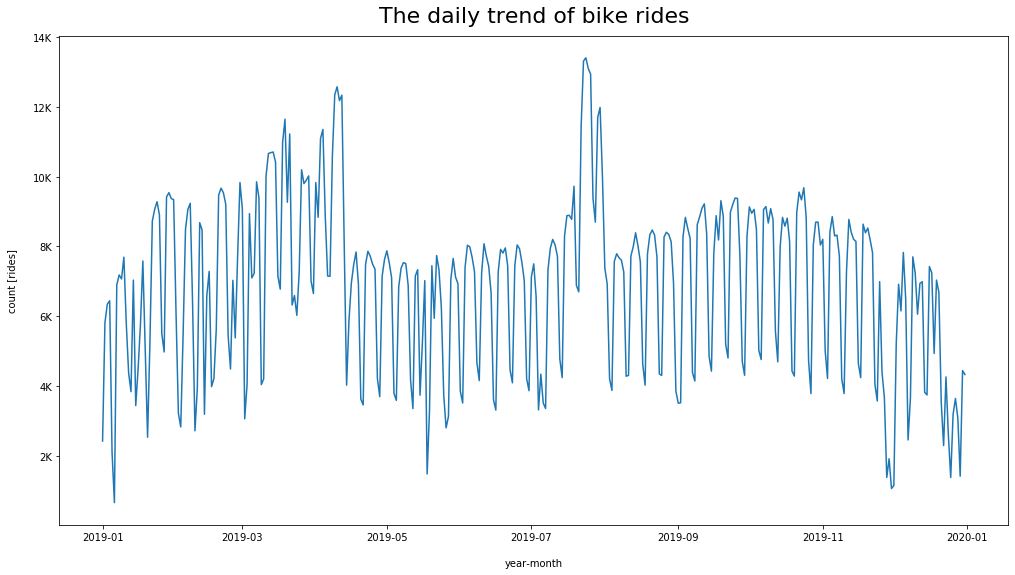

In [159]:
df_clean.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(17,9))
plt.title('The daily trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('daily_trend_bike_rides.png')

Compared to January 2019, where daily rides were less than 6K, it increased to more than 12,000 in July, after staying stable in the following months at around 8,000. There is huge decrease at the end of 2019, most likely b/c the winter season started and the weather go too cold. Also less tourists in the city.

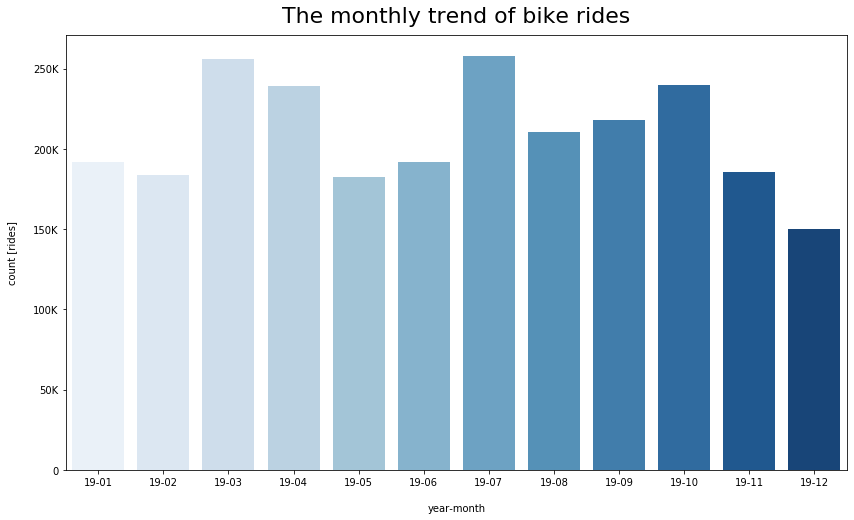

In [229]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_year_month_renamed', palette="Blues", data=df_clean.sort_values(by='start_time_year_month_renamed'))
plt.title('The monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('monthly_trend_bike_rides.png')

The previous findings are confirmed looking at monthly figures. Use of bike rides seems to be dependend on seasonality as there is a decline in the fall/ winter months. However, the number of bike rides remain relatively stable on average over the 12-months period. No growth seeable.

### Q.2 How is bike riding changing per hour and weekday?

#### Bike rides per weekday

In [215]:
trip_by_weekday_df = df_clean.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})

In [216]:
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bike_id']/trip_by_weekday_df['bike_id'].sum())*100

In [217]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

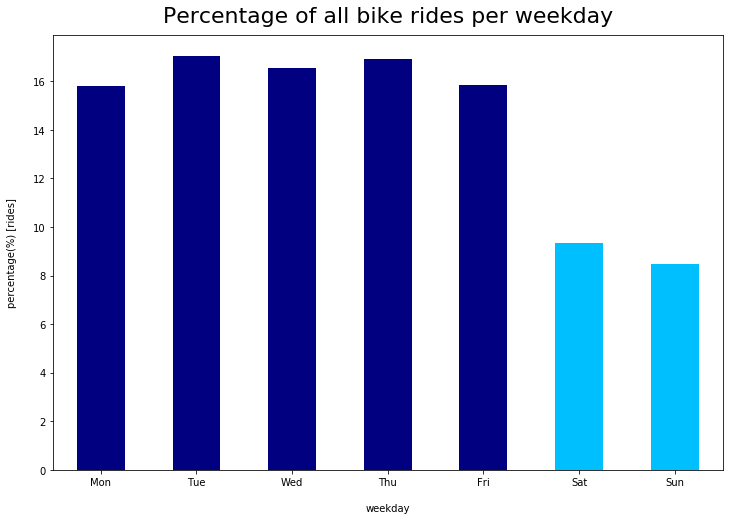

In [219]:
new_color = ['navy', 'navy', 'navy', 'navy', 'navy', 'deepskyblue', 'deepskyblue']
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('percentage_bike_rides_weekday.png')

The bike ride service is used more during the weekdays than on weekends.

#### Bike rides per hour

In total, absolute numbers:

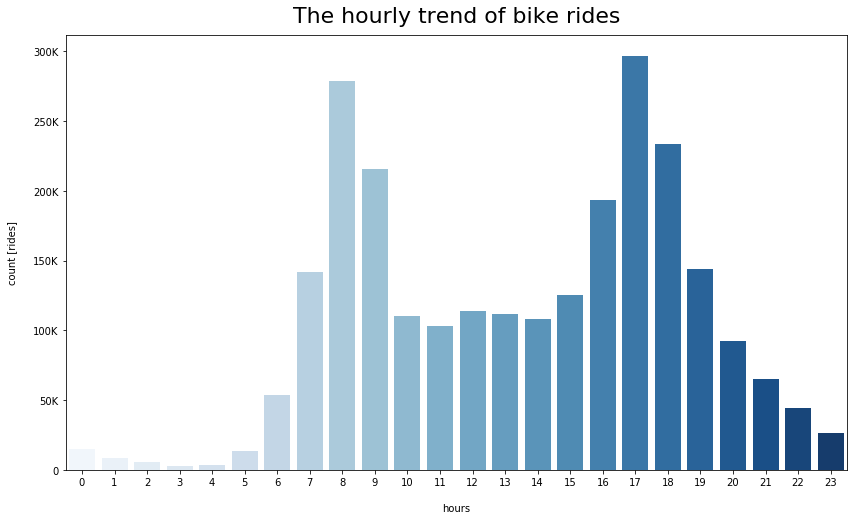

In [221]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_hour', palette="Blues", data=df_clean.sort_values(by='start_time_hour'))
plt.title('The hourly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('hours', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('hourly_trend_bike_rides.png')

Use of bike rides show peaks in the early-morning and late afternoon/ early evening. This is most likely b/c of commuters riding to/from work. Almost no usage happens during the night time. There is also a slight peak during noon, which is where people usually have lunch.

In relative (%) numbers:

In [166]:
trip_by_hour_df = df_clean.groupby('start_time_hour').agg({'bike_id':'count'}).reset_index()

In [167]:
trip_by_hour_df['bike_id'] = (trip_by_hour_df['bike_id']/trip_by_hour_df['bike_id'].sum())*100

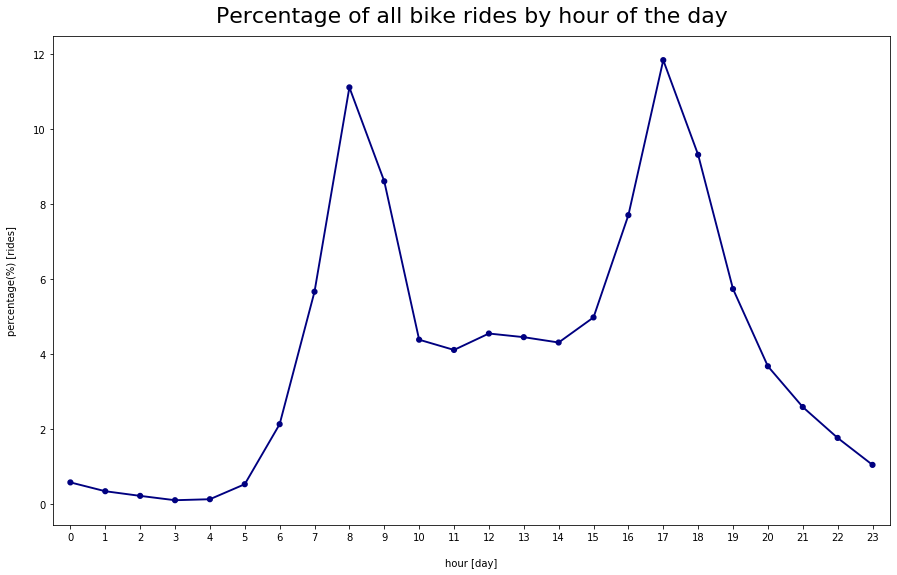

In [222]:
plt.figure(figsize=(15,9))
sns.pointplot(x='start_time_hour', y='bike_id', scale=.7, color='navy', data=trip_by_hour_df)
plt.title('Percentage of all bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.savefig('percent_all_bike_rides_hour.png')

This visual just shows the relative distribution of bike rides during the day. The sames insights and conclusions can be made compared with the previous visual.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

I checked each variables one by one. (Average rides, daily and monthly trend of riders, weekdays or weekends comparision, peak hours, user types with distances etc.). All these variables are important in order to understand the dataset and communicating the datafindings at the end of this project. Unfortunatly, the dataset did not include any information regarding demographics or the user, such as: gender, age or similar.

For example:       
- People use this service on weekdays more than weekends.  
- 8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.  

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
 
I generated new fields such as duration, time, etc. in order to calculate them easily and understand the dataframe. 

<a id='bivariate'></a>
## Part V - Bivariate Analysis

### Q.3 Is there any difference between groups ("customers" vs. "subscribers")?

#### Percentage of each group on total bike rides:

In [170]:
count_of_rides_per_user_type = df_clean.groupby('user_type').size().reset_index(name='count')

In [171]:
count_of_rides_per_user_type['count']/len(df_clean)*100

0    19.378552
1    80.621448
Name: count, dtype: float64

Percentage of subscribers is 80.62%.
<ul></ul>Percentage of customers is 19.38%.

#### Trends of user groups:

In [172]:
user_type_count_per_year_df = df_clean.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()

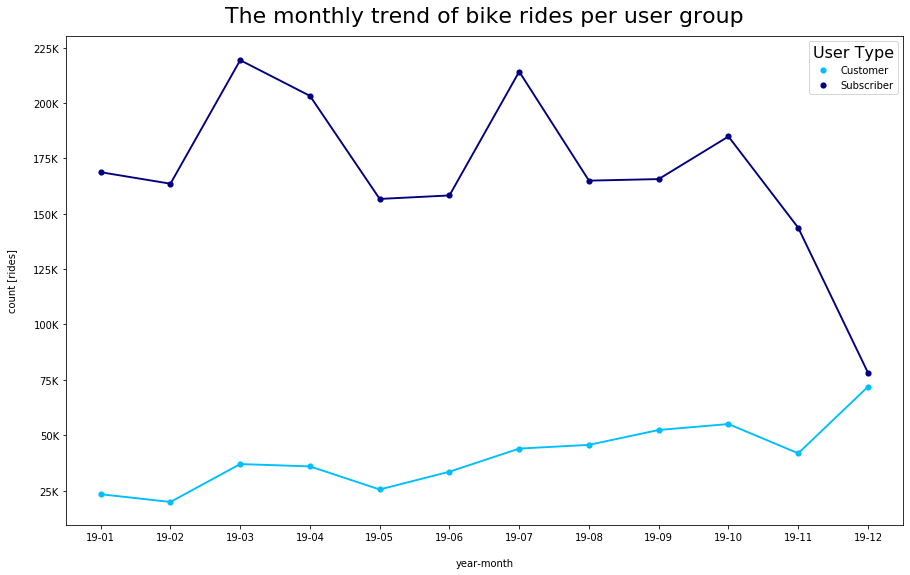

In [230]:
plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'navy', 'Customer':'deepskyblue'}
ax = sns.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_type_count_per_year_df)
plt.title('The monthly trend of bike rides per user group', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('monthly_trend_rides_user_groups.png')

Customers' rides seems increasing substantially.
There is a decrease since November 2019 for subscribers but it seems like it is related with winter season.

#### Average trip duration per user group:

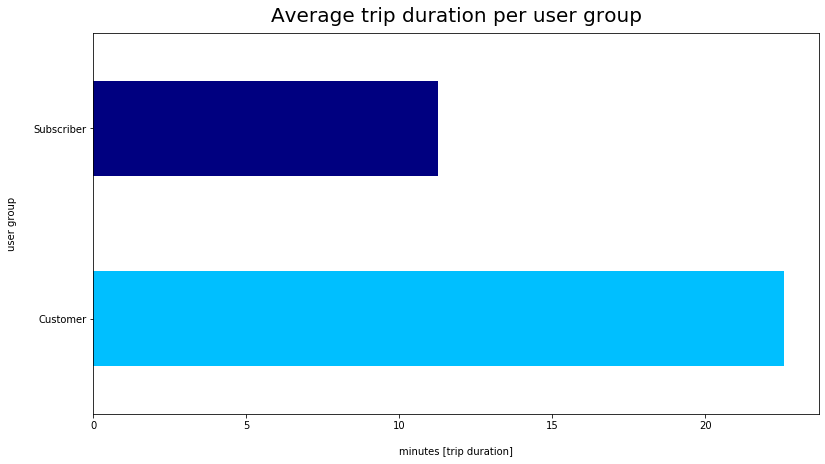

In [224]:
new_color=['deepskyblue', 'navy']
ax = df_clean.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user group', fontsize=20, y=1.015)
ax.set_ylabel('user group', labelpad=16)
ax.set_xlabel('minutes [trip duration]', labelpad=16)
plt.savefig('avg_trip_duration_user_group.png')

Subscribers' average trip duration is approx. 12 minutes.  
Customers' average trip duration is approx. 23 minutes.  

#### Average trip distance per user group:

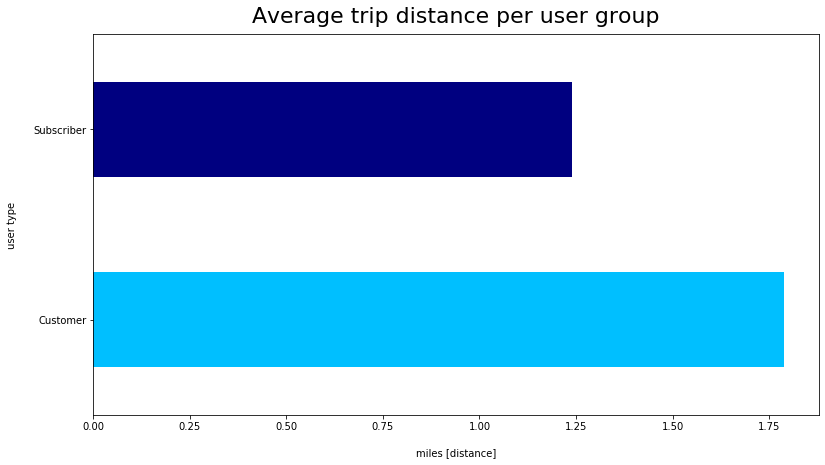

In [225]:
ax = df_clean.groupby('user_type')['distance_miles_estimates'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user group', fontsize=22, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('miles [distance]', labelpad=16)
plt.savefig('avg_trip_distance_user_group.png')

Subscribers' average trip distance is approx. 1.25 miles.  
Customers' average trip distance is approx. 1.75 miles.

There is a different trend on which days customers and subscribers rent bikes. As mentioned above **customers** are most probably occasional riders and tourist who use the bike sharing system on holiday or weekend trips. On the other hand, **subscribers** are most probably daily work/school commuters who use the system within a week.

#### Hourly usage per user group:

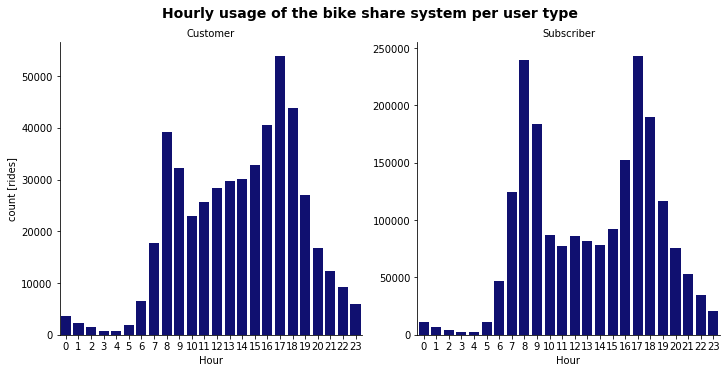

In [228]:
ax = sns.catplot(data=df_clean, x='start_time_hour', col="user_type", kind='count', sharey = False,
            color='navy')
ax.set_axis_labels("Hour", "count [rides]")
ax.set_titles("{col_name}")
ax.fig.suptitle('Hourly usage of the bike share system per user type', y=1.03, fontsize=14, fontweight='semibold')
plt.savefig('hourly_usage_user_group.png')

There is also a different trend of when during the day bikes are rented most often. **Customers** use bikes mainly between 8 am - 7 pm, reaching the renting peak around 5pm. **Subscribers** on the other side use the system at around 7-9am and 4-6pm when they go and come back from work.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

- Percentage of subscribers is 80.62%. Percentage of customers is 19.38%.  
- Customers' rides continously increase over the year.
- Subscribers' average trip duration is 12 minutes. Customers' average trip duration is around 23 minutes.  
- Subscribers and customers trip distance ranged from 1.25 and 1.75 respectively.    
- Subscribers most frequently used the service between 7-9am and 4-6pm.
- Customers used the service between 8am-9am, with a steady increase, reaching a peak at 5pm.
- Adding the user type to the analysis depicted different usage behaviours between customers and subscribers. As mentioned above **customers** are casual riders, most probably tourists who rent bikes mainly in summertime (the peak in July), and they rent bikes more often within the day rather than around commute hours (8-9am and 5pm). **Subscribers** are daily commuters, who also use the system around summertime, May-October (with the peak in October). They rent bikes mainly around the time they go and go back from work or school (7-9am and 4-6pm).

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

- There is a difference in the trip duration between customers and subscribers. **Customers** trips are usually longer than for subscribers, most probably due to the fact they prefer bike rides around weekends in summertime, what encourages longer trips around the area. **Subscribers** on the other hand use the system mainly for commute purposes so they rather prefer quick rides to and from work/school.

<a id='multivariate'></a>
## Part VI - Multivariate Analysis

### Q.4 What is the impact on whether a user is a subscriber or a customer?

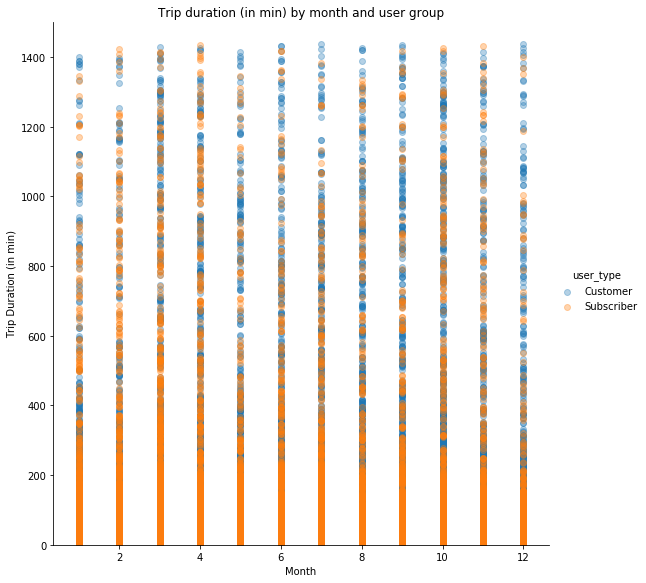

In [205]:
# here we focus on finding out if user group leads to lower trip duration

g = sns.FacetGrid(data =  df_clean, hue = 'user_type', height = 8)
g.map(plt.scatter, 'month_start','duration_min', alpha = 1/3)
g.add_legend()
plt.title('Trip duration (in min) by month and user group')
plt.xlabel('Month')
plt.ylabel('Trip Duration (in min)')
plt.ylim(0, 1500)
plt.savefig('trip_duration_month_user_typ.png')

From the above plots, we can conclude that the count of customers is higher compared to the Subscribers. Hence, the user group does have an impact on trip duration.

### Q.5 What are hourly usage trends between the different user groups?

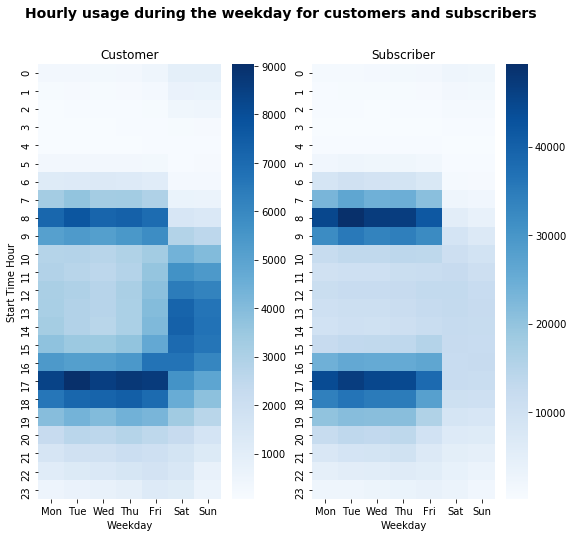

In [231]:
# setting the weekday order
df_clean['start_time_weekday'] = pd.Categorical(df_clean['start_time_weekday_abbr'], 
                                                categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], 
                                                ordered=True)
plt.figure(figsize=(9,8))
plt.suptitle('Hourly usage during the weekday for customers and subscribers', fontsize=14, fontweight='semibold')

# heatmap for customers
plt.subplot(1, 2, 1)
df_customer = df_clean.query('user_type == "Customer"').groupby(["start_time_hour", "start_time_weekday_abbr"])["bike_id"].size().reset_index()
df_customer = df_customer.pivot("start_time_hour", "start_time_weekday_abbr", "bike_id")
sns.heatmap(df_customer, cmap="Blues")

plt.title("Customer", y=1.015)
plt.xlabel('Weekday')
plt.ylabel('Start Time Hour')

# heatmap for subscribers
plt.subplot(1, 2, 2)
df_subscriber = df_clean.query('user_type == "Subscriber"').groupby(["start_time_hour", "start_time_weekday_abbr"])["bike_id"].size().reset_index()
df_subscriber = df_subscriber.pivot("start_time_hour", "start_time_weekday_abbr", "bike_id")
sns.heatmap(df_subscriber, cmap="Blues")

plt.title("Subscriber", y=1.015)
plt.xlabel('Weekday')
plt.ylabel('');

plt.savefig('hourly_usage_weekday_user_groups.png')

The plot summarizes in one place the diffrent trends for customers and subscribers, which has been analyzed above in previous sections.
<br>
#### Customers use the bike sharing system more often on weekends:
 * weekdays: most bike rides hapen around 7-9am and 4-6pm with the peak on Fridays around 5pm
 * weekends: most bike rides happen between 10am - 8pm with the peak on Saturdays around 2pm

#### Subscribers use the bike sharing system mainly on weekdays:
 * weekdays: most bike rides hapen around 7-9am and 4-6pm with the peak on Tuesdays around 8am
 * weekends: bikes are still rented but there is a significant drop in numbers of rented bikes throughout the entire weekends

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

- Plotting a heatmap of when bikes are high in demand throughout the day on each weekday shed a new light on the customers behaviour. Plotting the number of bike trips throughout the day and number of bike trips within the weekdays separately gave the impression that the demand for bikes is quite high throughout the day with a peak around 5pm which is not entirely true. The trend within weekdays for customers follows (although customers are rather not early birds) the one for subscribers who rent bikes mainly around commute hours (7-9am and 4-6pm). For customers, as depicted in above heat map, most of the trips happen on weekends but mainly between 10am - 8pm with the peak on Saturdays around 2pm, what was previosly not visible.

<a id='conclusion'></a>
## Conclusion

- People use this service on weekdays more than weekends.
- 8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.
- Percentage of subscribers is 80.62%. Percentage of customers is 19.38%.
- Customers' rides seems increasing slightly but subscibers' rides reached more than customers' in general. There is a decrease in November 2019 for subscribers but it seems like it is related with winter season.
- Subscribers' average trip duration is around 12 minutes. Customers' average trip duration is around 23 minutes.
- Subscribers and customers trip distance were 1.25 and 1.75 respectively.
- The majority of bike rides take place on weekday.
- The peak bike rides time for all members is around commute time.